In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
req_cols=['lat','long','medical','other_poi', 'park', 'school', 'Is_Adhoc']
df=pd.read_csv("./Processed_Bus_Trail_data.csv")[req_cols].copy()

#Markets
from libraries.gpsGrouper import distance
markets=pd.read_csv("markets.csv")[['lat','long']].values

def inMarket(cord,within=300):
    for lat,long in markets:
        if distance((cord[0],cord[1]),(lat,long))<within:
            return 1
    return 0

#Processing
df['Is_Adhoc']=df['Is_Adhoc'].apply(lambda e: 1 if e=="Adhoc" else 0)

#Making all PoIs as boolean variables (1- exist 0- does not exist)
df['inMarket']=df[['lat','long']].apply(lambda cord: inMarket(cord),axis=1)
df['medical']=df['medical'].apply(lambda e: 1 if e>0 else 0)
df['school']=df['school'].apply(lambda e: 1 if e>0 else 0)
df['park']=df['park'].apply(lambda e: 1 if e>0 else 0)
#Other_PoI=>  attraction,business,government,place_of_worship,sports_complex
df['other_poi']=df['other_poi'].apply(lambda e: 1 if e>0 else 0)
df['noPoI']=((df['inMarket']!=1) & (df['medical']!=1) & (df['school']!=1) & (df['park']!=1) & (df['other_poi']!=1)).apply(np.int32)
#New dataframe
df_new=df[['inMarket','medical','school','park','other_poi','noPoI','Is_Adhoc']].copy()
df_need=df_new.copy()
df_new=df_new[df_new.Is_Adhoc==1].copy()
df_new['Is_Adhoc']=df_new.Is_Adhoc.cumsum().apply(lambda e:f'adhoc_{e}')

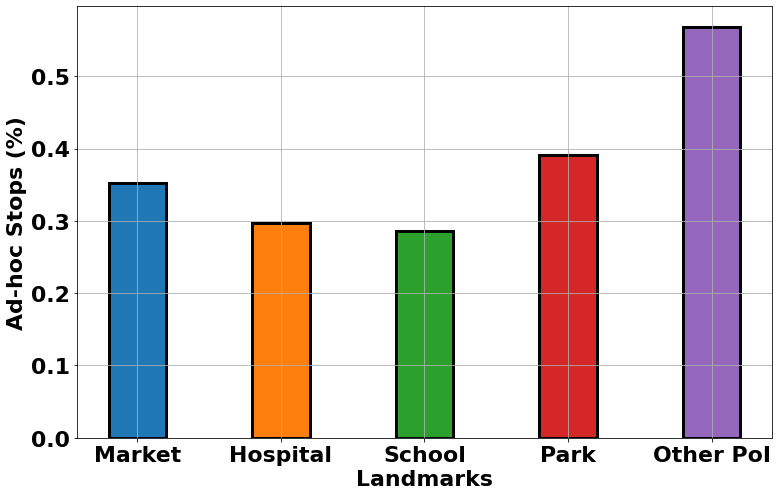

In [3]:
PoI_Adhoc=\
dict(market=(df_need[df_need['inMarket']==1]['Is_Adhoc'].mean()),
medical=(df_need[df_need['medical']==1]['Is_Adhoc'].mean()),
school=(df_need[df_need['school']==1]['Is_Adhoc'].mean()),
park=(df_need[df_need['park']==1]['Is_Adhoc'].mean()),
other_poi=(df_need[df_need['other_poi']==1]['Is_Adhoc'].mean()))

fig, ax = plt.subplots(figsize=(11,7))
ax.bar(x=[1,3,5,7,9],height=PoI_Adhoc.values(),align='center', alpha=1, ecolor='k', capsize=10,color=sns.color_palette(), ec='k',linewidth=3)
ax.set_ylim(0)

ax.set_xlabel("Landmarks",fontsize=22, fontweight='bold')
ax.set_ylabel("Ad-hoc Stops (%)",fontsize=22, fontweight='bold')

ax.set_xticks([1,3,5,7,9])
ax.set_xticklabels(['Market','Hospital','School','Park','Other PoI'],fontsize=22, fontweight='bold')
plt.yticks(fontsize=22, fontweight='bold')
plt.tight_layout()
plt.grid()
fig.savefig("../4. MotivationPlots/plots/normalized_adloc_vs_poi.png")

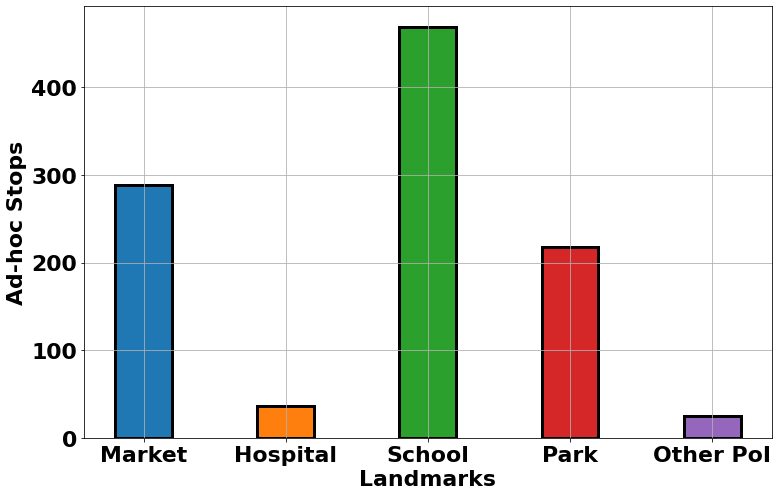

In [4]:
PoI_Adhoc=\
dict(market=len(df_new[df_new['inMarket']==1]['Is_Adhoc'].values),
medical=len(df_new[df_new['medical']==1]['Is_Adhoc'].values),
school=len(df_new[df_new['school']==1]['Is_Adhoc'].values),
park=len(df_new[df_new['park']==1]['Is_Adhoc'].values),
other_poi=len(df_new[df_new['other_poi']==1]['Is_Adhoc'].values))

fig, ax = plt.subplots(figsize=(11,7))
ax.bar(x=[1,3,5,7,9],height=PoI_Adhoc.values(),align='center', alpha=1, ecolor='k', capsize=10,color=sns.color_palette(), ec='k',linewidth=3)
ax.set_ylim(0)

ax.set_xlabel("Landmarks",fontsize=22, fontweight='bold')
ax.set_ylabel("Ad-hoc Stops",fontsize=22, fontweight='bold')

ax.set_xticks([1,3,5,7,9])
ax.set_xticklabels(['Market','Hospital','School','Park','Other PoI'],fontsize=22, fontweight='bold')
plt.yticks(fontsize=22, fontweight='bold')
plt.tight_layout()
plt.grid()
fig.savefig("../4. MotivationPlots/plots/num_adloc_vs_poi.png")

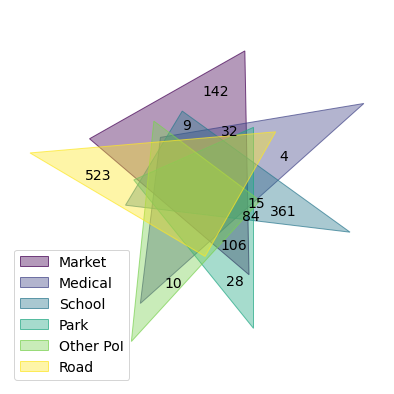

In [5]:
from itertools import product

num_elem=[]
setA=[];setB=[];setC=[];setD=[];setE=[];setF=[]
for A,B,C,D,E,F in product([0,1],repeat=6):
    setA.append(A);setB.append(B);setC.append(C);setD.append(D);setE.append(E);setF.append(F)
    filter=\
        (df_new['inMarket']==A) & (df_new['medical']==B) & (df_new['school']==C) & \
        (df_new['park']==D) & (df_new['other_poi']==E) & (df_new['noPoI']==F)
    count=df_new[filter].shape[0]
    num_elem.append(count)

df_set=pd.DataFrame({'Market':setA,'Medical':setB,'School':setC,'Park':setD,'Other PoI':setE,'Road':setF,'numElem':num_elem})
df_set=df_set[df_set.numElem>0].copy()

from collections import Counter
sets = Counter()
for A,B,C,D,E,F,N in df_set.values:
    sets[f'{A}{B}{C}{D}{E}{F}']=N
    
labels=list(df_set.columns)[:-1]

from venn import draw_venn, generate_colors
fig=plt.figure(figsize=(11,7))
ax=fig.add_subplot(111)
draw_venn(
    petal_labels=sets, dataset_labels=labels,
    hint_hidden=False, colors=generate_colors(n_colors=6),figsize=None,
    fontsize=14, legend_loc="best", ax=ax)

fig.savefig("../4. MotivationPlots/plots/num_adloc_vs_poi_venn.png")

In [ ]:
#NICE

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def time_zone_cal(s):
    hour=int(s.split(':')[0])
    if 6<hour<=9:
        time_zone='Early_Morning'
    elif 9<hour<=12:
        time_zone='Morning'
    elif 12<hour<=17:
        time_zone='Afternoon'
    elif 17<hour<=23:
        time_zone='Evening'
    return time_zone

In [3]:
def get_adhoc_tz_boxdata(trail_type="up"):
    files=glob.glob(f"./Trails/{trail_type}/*/All_DATA.csv")
    dfs=[]
    for idx,file in enumerate(files):
        df=pd.read_csv(file)
        df['TZ']=df['start_time'].apply(time_zone_cal)
        df['Adhoc']=df['Is_Adhoc'].apply(lambda e: 1 if e=='Adhoc' else 0)
        df['trail_id']=idx
        dfs.append(df[['trail_id','TZ','Adhoc']].copy())
    adhoc_tz=pd.concat(dfs).groupby(['TZ','trail_id'])['Adhoc'].sum()
    return adhoc_tz

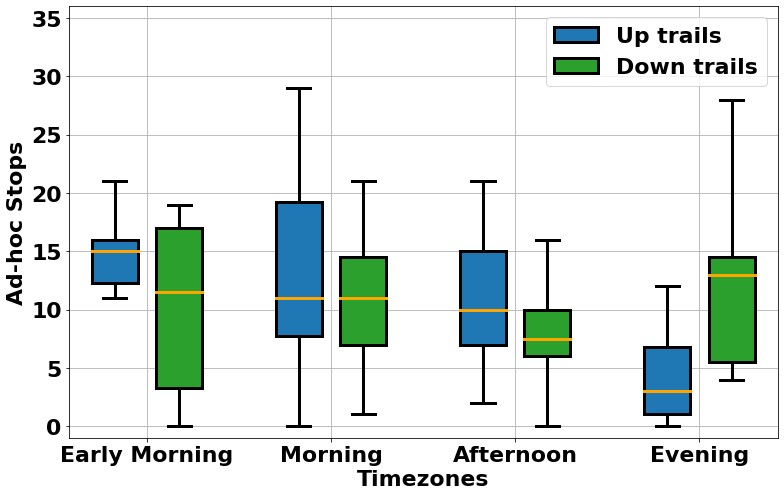

In [4]:
fig, ax = plt.subplots(figsize=(11,7))

pos=[1,3,5,7]
sep=0.7

adhoc_up=get_adhoc_tz_boxdata("up")
bp1=\
ax.boxplot([adhoc_up['Early_Morning'],adhoc_up['Morning'],adhoc_up['Afternoon'],adhoc_up['Evening']],
            positions=pos,
            showfliers=False,notch=False,patch_artist=True, 
            boxprops=dict(linewidth=3.0,color='black',facecolor="C0"),
            whiskerprops = dict(linestyle='-',linewidth=3.0, color='black'),
            capprops=dict(linestyle='-',linewidth=3.0, color='black'),
            medianprops=dict(linestyle='-',linewidth=3.0, color='orange')
          )

adhoc_down=get_adhoc_tz_boxdata("down")
bp2=\
ax.boxplot([adhoc_down['Early_Morning'],adhoc_down['Morning'],adhoc_down['Afternoon'],adhoc_down['Evening']],
            positions=[e+sep for e in pos],
            showfliers=False,notch=False,patch_artist=True, 
            boxprops=dict(linewidth=3.0,color='black',facecolor="C2"),
            whiskerprops = dict(linestyle='-',linewidth=3.0, color='black'),
            capprops=dict(linestyle='-',linewidth=3.0, color='black'),
            medianprops=dict(linestyle='-',linewidth=3.0, color='orange')
          )

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Up trails', 'Down trails'],
          prop={'size':22,'weight':'bold'},loc='upper right')

ax.set_xlabel("Timezones",fontsize=22, fontweight='bold')
ax.set_ylabel("Ad-hoc Stops",fontsize=22, fontweight='bold')

ax.set_xticks([1.35,3.35,5.35,7.35])
ax.set_ylim(-1,36)
ax.set_xticklabels(['Early Morning','Morning','Afternoon','Evening'],fontsize=22, fontweight='bold')
plt.yticks(fontsize=22, fontweight='bold')
plt.tight_layout()
plt.grid()
fig.savefig("../4. MotivationPlots/plots/adloc_tz_trail_box.png")

In [ ]:
#NICE